### LIBRARY

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

### DATASET

In [18]:
df = pd.read_csv("DATA.csv")

X = df.iloc[:, :2].values 

def min_max_scale(values):
    min_val = values.min(axis=0)
    max_val = values.max(axis=0)
    return (values - min_val) / (max_val - min_val)

X = min_max_scale(X)

### EUCLIDEAN DISTANCE

In [19]:
def euclidean_distance(a, b):
    return np.sqrt(np.sum((a - b) ** 2, axis=1))

### K-MEAN CLUSTERING

In [ ]:
def k_means(X, k, epochs=1000):
    np.random.seed(23)  
    
    centroids = X[np.random.choice(X.shape[0], k, replace=False)]

    for _ in range(epochs):
        clusters = {i: [] for i in range(k)}

        for point in X:
            distances = euclidean_distance(point, centroids)
            cluster_index = np.argmin(distances)
            clusters[cluster_index].append(point)

        new_centroids = np.array([np.mean(clusters[i], axis=0) if clusters[i] else centroids[i] for i in range(k)])
        
        if np.all(centroids == new_centroids):
            break
        centroids = new_centroids

    return centroids, clusters

## PLOTS

In [48]:
def plot_clusters(X, centroids, clusters, k, filename):
    plt.figure(figsize=(8, 6), dpi=500)

    colors = ['cyan', 'red', 'purple']
    label_shown = [False] * k

    for cluster_idx in range(k):
        cluster_points = np.array(clusters[cluster_idx])
        for i in range(len(cluster_points)):
            if not label_shown[cluster_idx]:
                plt.scatter(
                    cluster_points[i, 0], cluster_points[i, 1],
                    color=colors[cluster_idx], label=f'CLUSTER {cluster_idx + 1}',
                    edgecolor='black', s=100, linewidth=2
                )
                label_shown[cluster_idx] = True
            else:
                plt.scatter(
                    cluster_points[i, 0], cluster_points[i, 1],
                    color=colors[cluster_idx], edgecolor='black',
                    s=100, linewidth=2
                )

    plt.scatter(
        centroids[:, 0], centroids[:, 1], color='black', marker='X',
        s=250, linewidth=3, edgecolor='black', label='CENTRIODS'
    )

    plt.xlabel("FEATURE-1", fontsize=18, fontweight='bold')
    plt.ylabel("FEATURE-2", fontsize=18, fontweight='bold')

    plt.tick_params(axis='both', which='major', labelsize=16, width=2)
    for label in plt.gca().get_xticklabels() + plt.gca().get_yticklabels():
        label.set_fontweight('bold')

    plt.title(f"K-MEANS CLUSTERING (k={k})", fontsize=20, fontweight='bold')

    plt.grid(True, linestyle='--', alpha=0.7)

    legend = plt.legend(loc='upper left', fontsize=14, frameon=True, fancybox=True, shadow=True, borderpad=1.5)
    for text in legend.get_texts():
        text.set_fontweight('bold')

    plt.tight_layout()
    plt.savefig(rf"C:\Users\KIIT\Documents\AI_LAB\K-MeanClustering\{filename}.png", dpi=500, bbox_inches='tight')
    plt.show()

### K=2

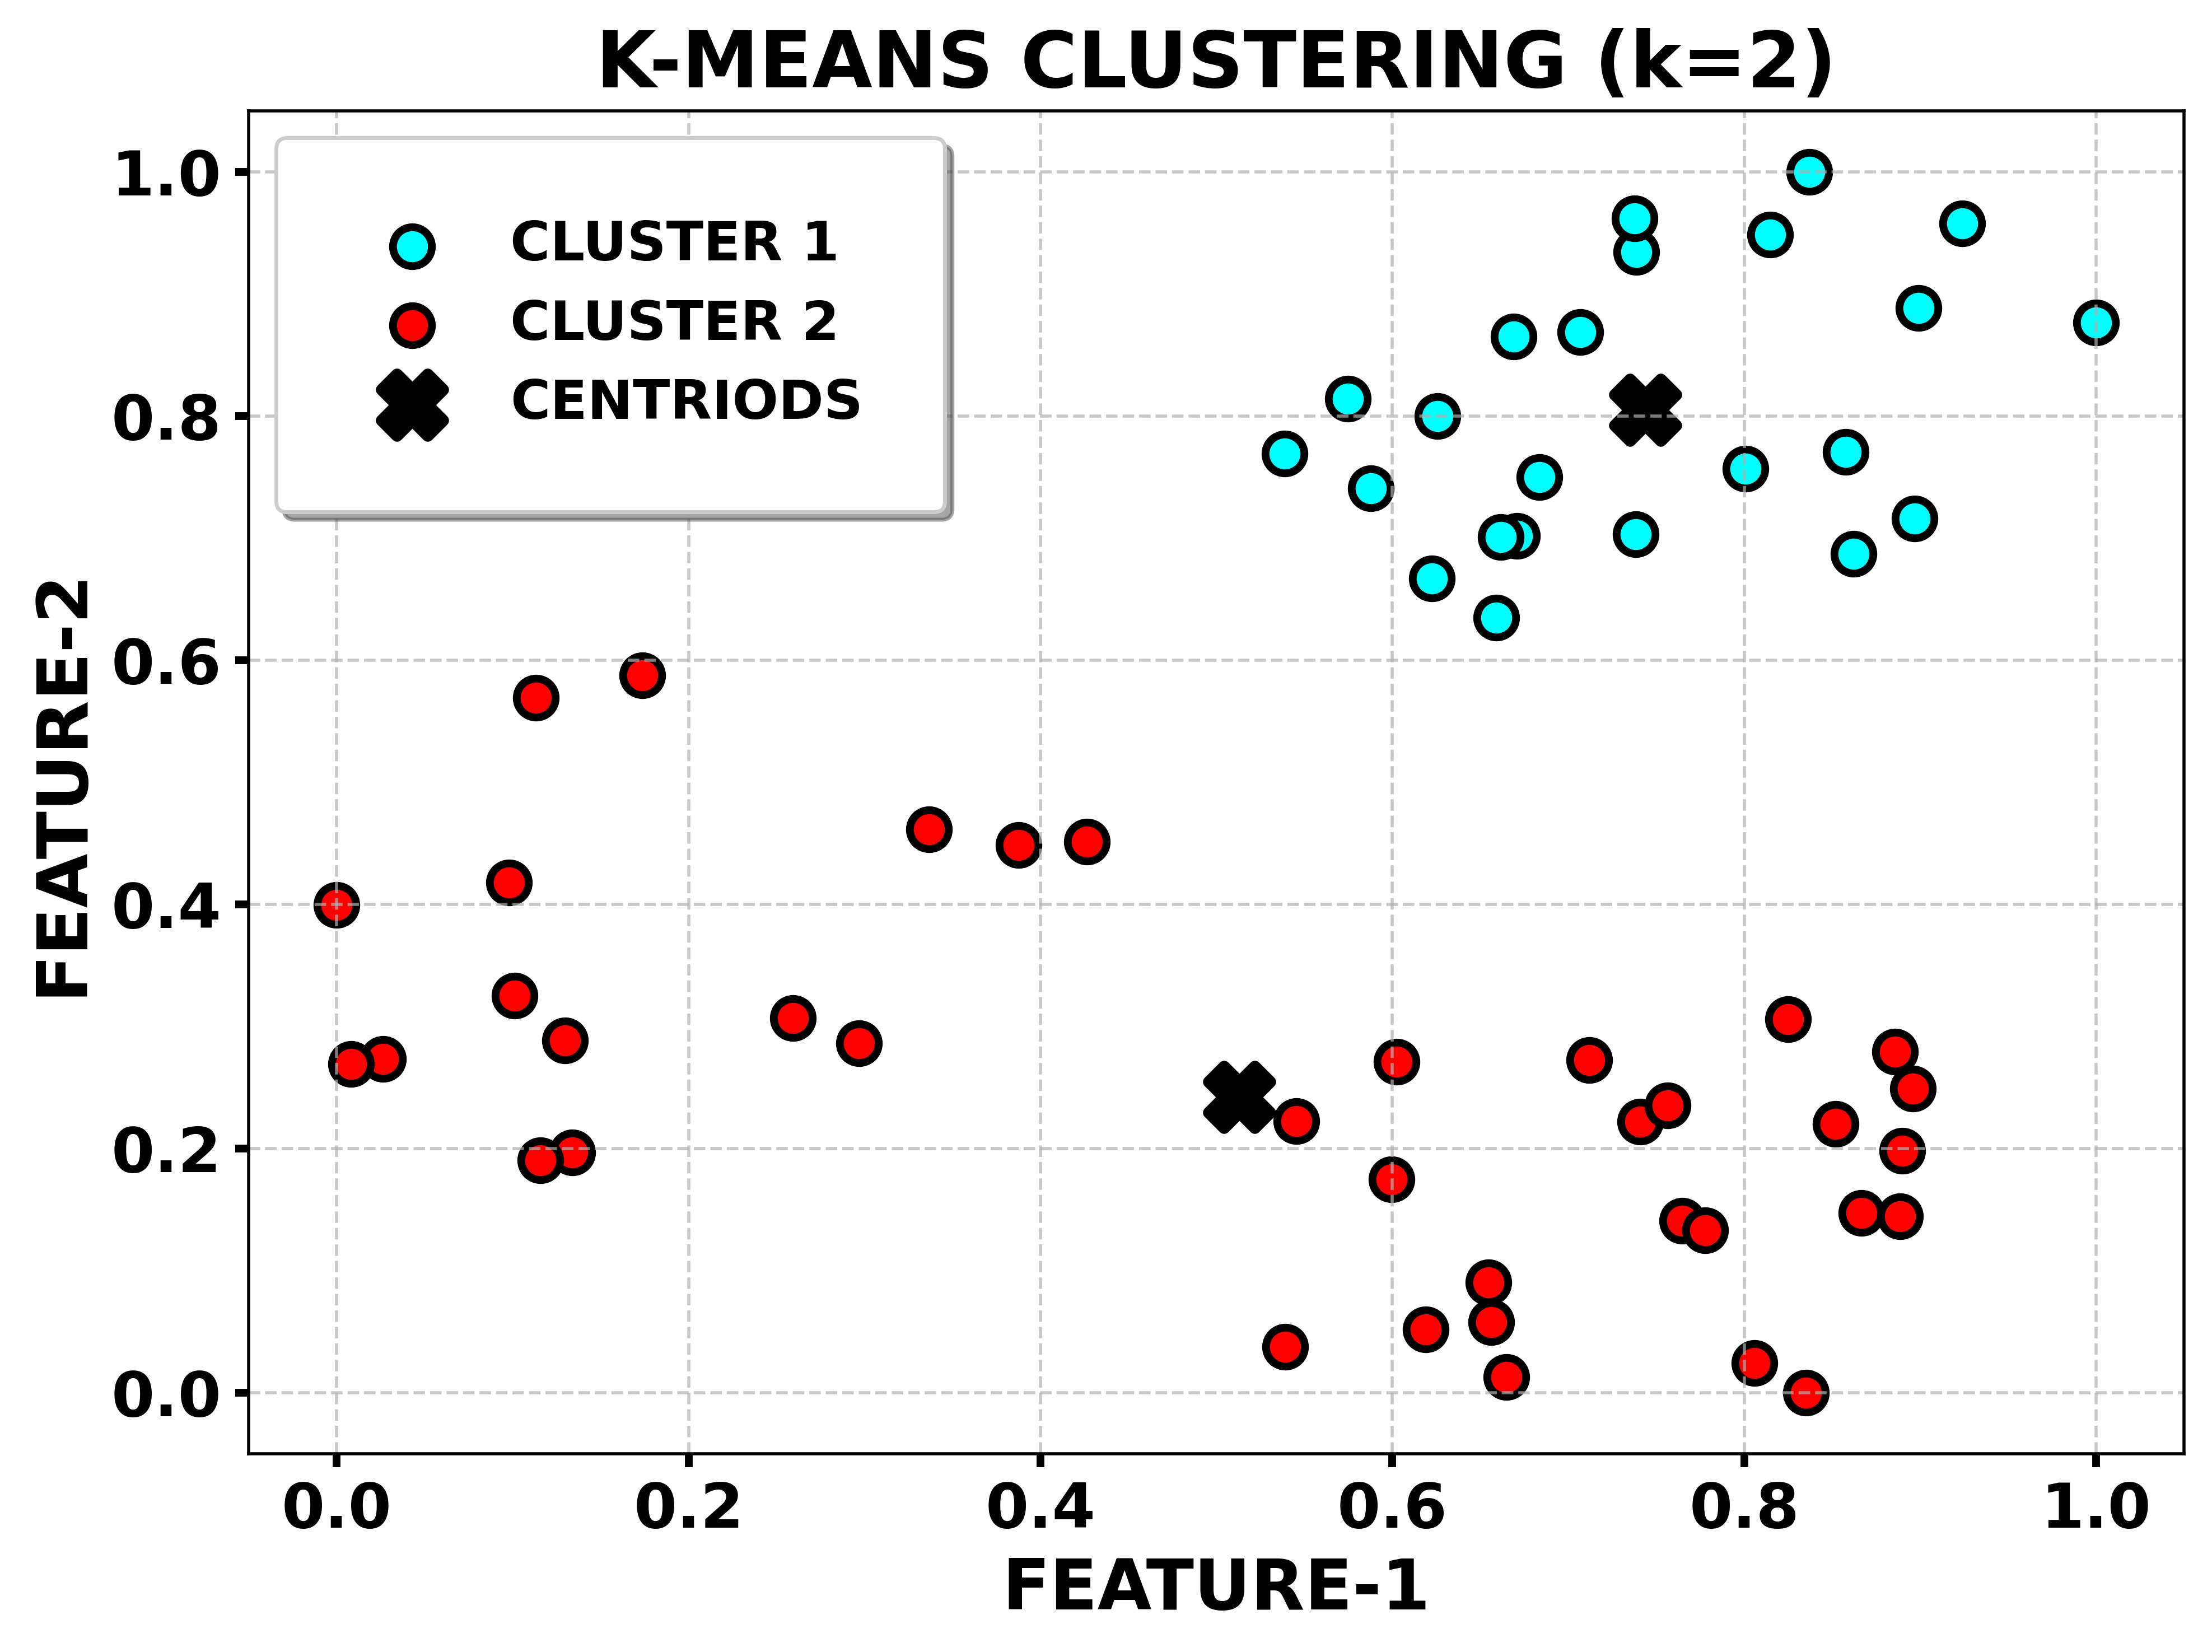

In [49]:
centroids, clusters = k_means(X, 2)
plot_clusters(X, centroids, clusters, 2, "k2")

### K=3

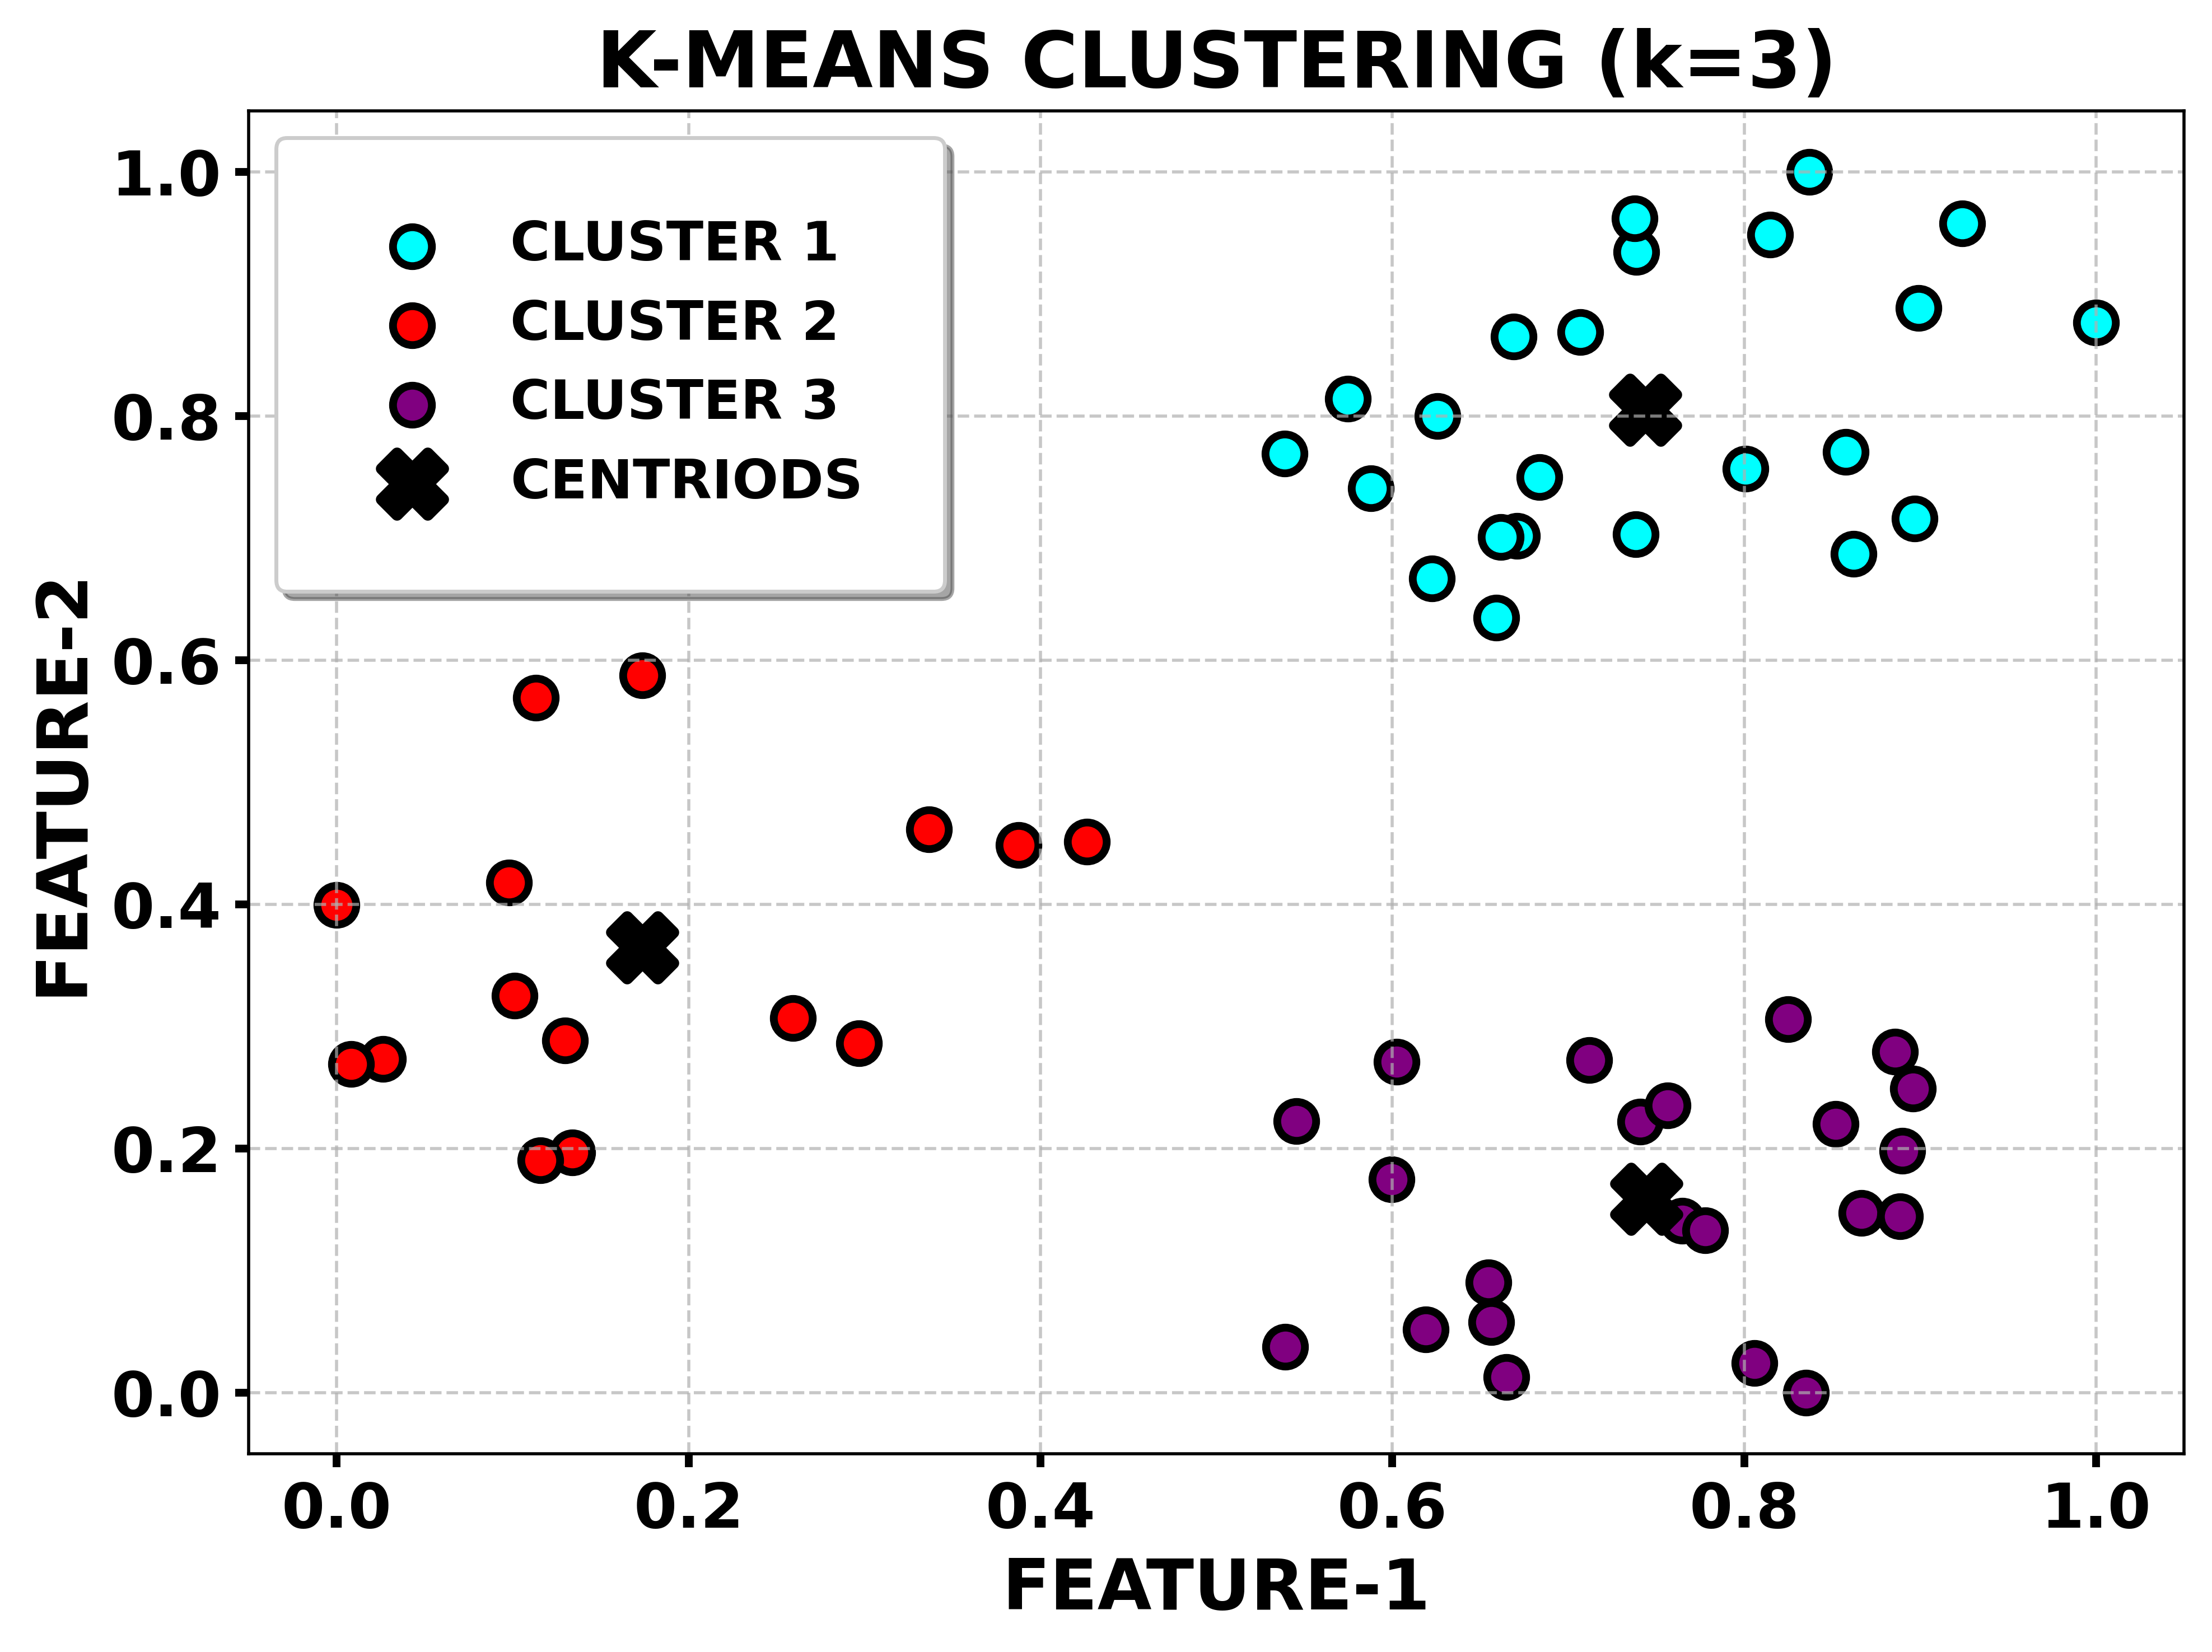

In [50]:
centroids, clusters = k_means(X, 3)
plot_clusters(X, centroids, clusters, 3, "k3")